## Segmentation

To better understand the behaviour of ships in port K means clustering is used to quantitatively classify behaviour on an individual ship-by-ship basis. The clusters or segments resulting from the k means clustering align to the stages of a ships journey such as docked. These behavioural states transform the AIS data to a more meaningful and interpretable representation which can be used to better understand the behaviour of a ship at any point on its voyage.

The behaviours used in the clustering are ROT and SOG. These variables are selected due to their frequency, accuracy and generality. 

To find the best number of clusters/segments a sample of MMSI and timepoints is used.

In [1]:
%matplotlib inline

# base libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.externals import joblib
import folium as fm
from folium.plugins import HeatMap
import branca
import seaborn as sns
import os 
import json

In [3]:
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
shipping_rot_filename = config['DEFAULT']['shipping_rot_filename']
seg_prep_filename = config['DEFAULT']['seg_prep_filename']
kmeans_model = config['DEFAULT']['kmeans_model']

In [4]:
# import data
seg_prep = pd.read_csv(processing_path + seg_prep_filename,header = 0,delimiter = ',')
seg_prep.rename(columns={'Unnamed: 0':'MMSI','Unnamed: 1':'dt'},inplace=True)
seg_prep['dt'] = pd.to_datetime(seg_prep["dt"])

In [5]:
# drop null values
# seg_prep[seg_prep.isnull().any(axis=1)]
seg_prep = seg_prep.dropna()

### Applying k-means clustering

kmeans unsupervised algorithm is applied to the training data, the number of generated segments (k) was set to an arbitrarily large value of eight. Segments that are similar based upon their centroids as defined by the ROT and SOG state vectors will be merged.

In [6]:
var_list = ['SOG_0','SOG_1','SOG_2','SOG_3','SOG_4','SOG_5', 'SOG_6','rot_0','rot_1','rot_2','rot_3','rot_4']

In [7]:
# the kmeans algorithm is seeded to generate consistent results across runs
kmeans = KMeans(n_clusters = 8,random_state = 1234)
kmeans.fit(seg_prep[var_list])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [8]:
centroids = kmeans.cluster_centers_

In [9]:
scored = kmeans.predict(seg_prep[var_list])
scored = pd.DataFrame(scored)
scored.columns = ['segment']

In [10]:
# join the segment back onto the orignal data
scored = seg_prep.merge(scored,left_index = True,right_index = True,how = 'inner')

In [11]:
# get the real centroids (the other ones are transformed)
centroids_true = scored.groupby('segment')[var_list].mean()

In [12]:
# merge the segment sizes onto the centroid data and rename column
seg_counts = scored['segment'].value_counts()
seg_counts = pd.DataFrame(seg_counts)
seg_counts.columns = ['count']

centroids_true = centroids_true.merge(seg_counts,left_index = True,right_index = True,how = 'inner')

In [13]:
# save the model
joblib.dump(kmeans, processing_path + kmeans_model)

['/Users/soniawilliams/Desktop/AIS/processing/kmeans_model.pkl']

## Visualising segments

A heatmap of lat and long points within each segment is used to validate the segments. If the segments are robust then it's expected that the lat long points will be tightly grouped in separate areas to each other and that the behaviour of the ships at that point is identifiable. The heatmaps suggest the segments fall into three higher level behavioural groups Transitional behaviour, Docking behaviour and Docked behaviour. A table also indicates where each segment over indexes (dark green) within the SOG and ROT input state vectors.

### Index Table
The index table highlights where each segment over indexes for each band of ROT and SOG. The darker the shade of green the more the segment over indexes. The segment relating to Docked behaviour over indexes for a very low SOG and a high ROT. The index table demonstrates the seperation of the clusters based on ROT and SOG.

In [14]:
# get numbers of GPS points within each segment and SOG/ROT measure
all_seg_counts = scored.groupby('segment')[var_list].sum()

In [16]:
# function to convert a value to the percentage of the row total
def get_pct(x):
    return(x/(x.sum()))

In [17]:
# convert counts to percentage distibution across bins
sog_perc = all_seg_counts[['SOG_0','SOG_1','SOG_2','SOG_3','SOG_4','SOG_5','SOG_6']]
sog_perc = sog_perc.apply(get_pct,axis = 0)

rot_perc = all_seg_counts[['rot_0','rot_1','rot_2','rot_3','rot_4']]
rot_perc = rot_perc.apply(get_pct,axis = 0)

In [18]:
# convert total counts for each segment into a percentage
seg_counts2 = seg_counts.apply(get_pct,axis=0)
seg_counts2 = seg_counts2.sort_index()
seg_counts3 = seg_counts2.iloc[:,0]

In [19]:
# convert the percentages to an index against the total segment counts
sog_idx = round(sog_perc.divide(seg_counts3,axis=0),4)
rot_idx = round(rot_perc.divide(seg_counts3,axis=0),4)

Text(373.364,0.5,'Segment')

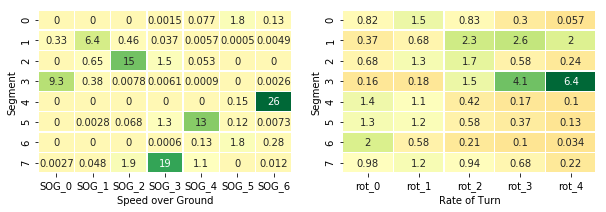

In [20]:
# plot the index tables, indicating where the segment over indexes for speed and rate of turn
f = plt.figure(figsize=(10,3))

f.add_subplot(121)
ax1 = sns.heatmap(sog_idx,center=1,linewidths=.5,cmap="RdYlGn",cbar=False, annot=True)
plt.xlabel('Speed over Ground')
plt.ylabel('Segment')

f.add_subplot(122)
ax2 = sns.heatmap(rot_idx,center=1,linewidths=.5,cmap="RdYlGn",cbar=False, annot=True)
plt.xlabel('Rate of Turn')
plt.ylabel('Segment')

### Heatmaps

Each time the clusters are regenerated the segments may come out in a different order. The commentary below is relevant to the clusters generated before the code was pushed. 

In [21]:
# rejoin lat and long
dtype_dic = {'MMSI':int,'dt':'str', 'lat':'float', 'long':'float','SOG':'float', 'rot':'float', 
             'Type':'str', 'gross_tonnage':'float','vessel_name':'str', 'ETA':'str', 'POC_LOCODE':'str',
             'last_port_LOCODE':'str', 'next_port_LOCODE':'str', 'status':'str','voyage_id':'float','tripid':int,
            'in_hazmat':'str','out_hazmat':'str'}
parse_dates = ['dt', 'ETA']

shipping_data = pd.read_csv(processing_path + shipping_rot_filename,header = 0,delimiter = ',',dtype = dtype_dic, parse_dates=parse_dates)

scored_wll = scored.merge(shipping_data[['MMSI','dt','lat','long']],how = 'inner', on = ['MMSI','dt'])

In [39]:
map_location = [51.9506,1.295]
map_zoom = 13
map_width = '48%'
map_height = '48%'
map_position='absolute'

segment = {}

for seg in list(seg_counts.index):          
    
    segment['data'+str(seg)] = scored_wll[scored_wll['segment'] == seg]
    segment['data'+str(seg)] = segment['data'+str(seg)][:10000]

    # Create list of tuples to plot 
    segment['points'+str(seg)] = segment['data'+str(seg)][['lat','long']].values.tolist()

map0 = fm.Map(width=map_width, height=map_height, position=map_position, left='0%', top = '0%', location = map_location, zoom_start=13)
map1 = fm.Map(width=map_width, height=map_height, position=map_position, left='0%', top= '0%', location = map_location, zoom_start=13)
map2 = fm.Map(width=map_width, height=map_height, position=map_position, left='50%', top = '0%', location = map_location, zoom_start=13)
map3 = fm.Map(width=map_width, height=map_height, position=map_position, left='0%', top = '0%', location = map_location, zoom_start=13)
map4 = fm.Map(width=map_width, height=map_height, position=map_position, left='50%', top = '0%', location = map_location, zoom_start=13)
map5 = fm.Map(width=map_width, height=map_height, position=map_position, left='0%', top= '50%', location = map_location, zoom_start=13)
map6 = fm.Map(width=map_width, height=map_height, position=map_position, left='50%', top = '50%', location = map_location, zoom_start=13)
map7 = fm.Map(width=map_width, height=map_height, position=map_position, left='0%', top = '50%', location = map_location, zoom_start=13)

HeatMap(segment['points0'], radius = 4, blur = 3).add_to(map0)
HeatMap(segment['points1'], radius = 4, blur = 3).add_to(map1)
HeatMap(segment['points2'], radius = 4, blur = 3).add_to(map2)
HeatMap(segment['points3'], radius = 4, blur = 3).add_to(map3)
HeatMap(segment['points4'], radius = 4, blur = 3).add_to(map4)
HeatMap(segment['points5'], radius = 4, blur = 3).add_to(map5)
HeatMap(segment['points6'], radius = 4, blur = 3).add_to(map6)
HeatMap(segment['points7'], radius = 4, blur = 3).add_to(map7)


### Transitional behaviour

The first four heatmaps display segment 0, 4, 5 and 6. 

Ships within the four transitional segments do not dock within the port and are not in the process of docking. Instead they use the port to transition into other inland areas. In the case of Felixstowe this is either heading east to the port of Harwich or north west to other inland destinations. 

The segment 4 has the highest speed of all segments, its ROT is typically low indicating that ships in this segment are not manoeuvring to any significant degree. The heatmap shows that there is a higher density of points located around the southern border of the port. It is suggested that this segment represents ships that are entering port and slowing down from their open water cruising speed to the speed limit within the port.

The other segments are closely related to segment 4. Although the ROT distributions are similar, the speed of the ships in this segment are significantly lower. This coupled with the heatmap, which shows no noticeable increase in density, suggests that these ships have passed the port boundary and are observing the local speed limit whilst they transition through the port.

As segments 0, 5 and 6 share a similar distribution they will be merged.

In [35]:
f1 = branca.element.Figure()
f1.add_child(map0)
f1.add_child(map4)
f1.add_child(map5)
f1.add_child(map6)

### Docking behaviour

The four heatmaps display segments 1, 2 and 7.

The docking segments classify ships that have initiated the process of docking into one of the harbour berths. There are three docking segments, each one relates to a unique phase of the docking process.

The speed of ships within segment 7 have dropped below that of the transitional phase ships. Their AIS points on the heat map indicate that they are turning towards the harbour berths.  Ships classified within segment 2 have decreased their speed further and are also starting to manoeuvre into dock (indicated by increasing ROT values).  The final docking segment, segment 1, is characterised by very slow speeds (less than one knot) and high ROT values. Ships in this segment are in the final stages of docking and are turning into their intended berth at very slow speeds and higher rates of turn. The heatmap for this illustrates the vicinity of the ships to the harbour wall.

In [40]:
f2 = branca.element.Figure()
f2.add_child(map1)
f2.add_child(map2)
f2.add_child(map7)

### Docked behaviour

The remaining heatmap displays segment 3.

The final segment relates to ships that have reached their destination. Ships within this segment have virtually no speed, the high rates of turn relate to the very final stages of the docking process where final adjustments are made to the ship position within the port. This heatmap for the segment confirms that the ships are all docked or very close to being so.

In [32]:
f3 = branca.element.Figure()
f3.add_child(map3)

## Merging Segments

From the index table and heatmaps above segments 1, 4 and 6 share a similar distribution for ROT and SOG. Segments that are similar based upon their centroids as defined by the ROT and SOG state vectors are merged together giving a final set of six unique segments.

As mentioned above the order segments may vary each time the clusters are generated. In this case the mapping of segments, segment_names list below will need to be updated.

In [41]:
scored6 = scored.copy()
scored6['segment'] = scored6['segment'].map({0:0, 1:1, 2:2, 3:3, 4:4, 5:0, 6:0, 7:5})
scored6['segment'] = scored6['segment'].astype(int)

In [42]:
# get the real centroids (the other ones are transformed)
centroids_true6 = scored6.groupby('segment').mean()
centroids_true6.drop('MMSI', axis=1, inplace=True)

## TSNE

The inputs to the segmentation algorithm are two state vectors consisting of a total of 12 values. The centroid of each of the six segments can be defined within 12-dimension space. t-SNE (t-distributed Stochastic Neighbour Embedding) a dimensionality reduction technique is applied to reduce the 12-dimensional data into 2-dimensions so that the spatial separation of each segment may be explored.

In [43]:
# apply t-SNE to reduce the data to two dimensions
# the kmeans algorithm is seeded to generate consistent results across runs
tsne = TSNE(learning_rate = 100,random_state = 1234)
tsne_centroids = tsne.fit_transform(centroids_true6)

In [44]:
# convert to dataframe
tmp = pd.DataFrame(tsne_centroids)
tmp['segment'] = tmp.index

In [53]:
# define a dictionary for colour coding the segments
colour_dict = {0:'lightgreen',
               1:'white',
               2:'pink',
               3:'orange',
               4:'darkgreen',
               5:'red'}
segment_names  = ['General','Terminal','Mid','Docked','Border','Initial']
tmp['seg_colour'] = tmp['segment'].map(colour_dict)

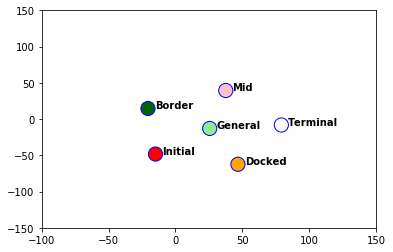

In [54]:
# plot the two dimensional data
x = tmp.iloc[:,0]
y = tmp.iloc[:,1]
colours = tmp['seg_colour']
labels = tmp['segment']

plt.rcParams['axes.facecolor'] = 'white'
plt.xlim(-100, 150)
plt.ylim(-150, 150)
plt.scatter(x,y,c=colours,edgecolor='b',s=200,label=segment_names)
for i, txt in enumerate(segment_names):
    plt.annotate(txt, (x[i]+5,y[i]),weight = 'bold')
plt.show()